**Machine Learning for Cyber Security Lab 1: Adversarial Attacks on Deep Neural Networks**

Submitted by: *Vaishnavi Rajput*

Net Id: *vr2229*

***Problem 0: Create 2-layer dense neural network***

Implementation of baseline model

In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from PIL import Image as im
from google.colab import files

In [2]:
# Download Fashion MNIST dataset.
# Normalize the images
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Generate the baseline model
# 28 x 28 dimensional input
# 300 hidden neurons and ReLU activation 
# 10 dimensional output
baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'), 
  tf.keras.layers.Dense(10) 
])

In [4]:
# Compute cross entropy loss between labels and predictions
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [5]:
# Compile the baseline model
baseline_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [6]:
# Fit the baseline model
baseline_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 19s 9ms/step - loss: 0.4819 - accuracy: 0.8275
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3640 - accuracy: 0.8671
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3265 - accuracy: 0.8807
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3047 - accuracy: 0.8884
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2850 - accuracy: 0.8941


In [7]:
# Evaluate baseline model
baseline_model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3523 - accuracy: 0.8752 - 777ms/epoch - 2ms/step


[0.3523190915584564, 0.8751999735832214]

In [8]:
# Define epsilon values in a list
epsilonvalues = [25/255,50/255,75/255,125/255]

In [9]:
# Define step-size
beta = 0.357

In [10]:
alpha = [(beta * x ) for x in epsilonvalues]

In [11]:
# Function to segregate test data which is getting correctly classified
def findCorrectClass(model,X, Y):
  x_correct = []
  y_correct = []
  
  for i, img in enumerate(X):
    img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      x_correct.append(tf.convert_to_tensor(img, dtype=tf.float32))
      y_correct.append(tf.convert_to_tensor(Y[i]))
  return  x_correct, y_correct

In [12]:
# Accuracy calculation for the model
def accuracy(model, xprime, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(xprime):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      pred_label.append(pred)
      count+=1
  return count/len(Y)

In [13]:
# Success rate calculation for the model
def success_rate(model, xprime, Y):
  count = 0
  for i, img in enumerate(xprime):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred != Y[i]:
      count+=1
  return count/len(Y)

***Problem 1: FGSM based untargeted attack***

$$
x'\leftarrow clip(x+\epsilon sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$

In this, we implement FGSM based untargeted attack using images from test set on the baseline DNN.

In [14]:
# Function to implement untargeted FGSM
def untarget_fgsm(model,X,Y,eps):
  # xprime = clip(X + eps(sign(grad(loss_correct))))
  xprime = []
  for i, img in enumerate(X):
    img = tf.convert_to_tensor(img, dtype=tf.float32)    
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(img)
      pred = model(img)
      loss = loss_fn(Y[i], pred)
    grad = tape.gradient(loss, img)
    grad_sign = tf.sign(grad)
    xprime.append(tf.clip_by_value((img + eps * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return xprime

In [15]:
x_correct,y_correct = findCorrectClass(baseline_model,x_test,y_test)

In [16]:
# Calculate model accuracy and success rate for different epsilon for untargeted attack
untarget_success_rate = []
untarget_accuracy = []
for a in alpha:
  xprime = (untarget_fgsm(baseline_model, x_correct, y_correct, a))
  untarget_success_rate.append(success_rate(baseline_model, xprime, y_correct))
  untarget_accuracy.append(accuracy(baseline_model, xprime,y_correct))

In [17]:
# Display model accuracy and success rate for different epsilon for untargeted attack
print ("Model accuracy and success rate for FGSM based untargeted attack:")
for ep, a, sr in zip(epsilonvalues, untarget_accuracy, untarget_success_rate):
  print ("Epsilon: ", "%.4f" % ep, ", accuracy: ", "%.4f" % (a * 100), ", success rate: ", "%.4f" % (sr * 100))

Model accuracy and success rate for FGSM based untargeted attack:
Epsilon:  0.0980 , accuracy:  65.7793 , success rate:  34.2207
Epsilon:  0.1961 , accuracy:  29.6618 , success rate:  70.3382
Epsilon:  0.2941 , accuracy:  10.5576 , success rate:  89.4424
Epsilon:  0.4902 , accuracy:  2.8565 , success rate:  97.1435


***Problem 2: Targeted attack- FGSM***

$$
x'\leftarrow clip(x-\epsilon sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$

In this, we implement FGSM based targeted attack using images from test set on the baseline DNN.

In [18]:
# Function to implement targeted FGSM
def target_fgsm(model, X, Y, ep):
  # xprime = clip(x - eps(sign(grad(loss_correct))))
  xprime =[]
  y_target = []
  for i in Y:
    y_target.append((i+1)%10)
  for i, img in enumerate(X):   
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_fn(y_target[i], pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    xprime.append(tf.clip_by_value((x_tensor - ep * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return xprime

In [19]:
# Calculate model accuracy and success rate for different epsilon for targeted attack
target_success_rate =[]
target_accuracy = []
for a in alpha:
  xprime = (target_fgsm(baseline_model, x_correct, y_correct, a))
  target_success_rate.append(success_rate(baseline_model, xprime,y_correct))
  target_accuracy.append(accuracy(baseline_model, xprime,y_correct))

In [20]:
# Display model accuracy and success rate for different epsilon for targeted attack
print ("Model accuracy and success rate for FGSM based targeted attack:")
for ep, a, sr in zip(epsilonvalues, target_accuracy, target_success_rate):
  print ("Epsilon: ", "%.4f" % ep, ", accuracy: ", "%.4f" % (a * 100), ", success rate: ", "%.4f" % (sr * 100))

Model accuracy and success rate for FGSM based targeted attack:
Epsilon:  0.0980 , accuracy:  88.6883 , success rate:  11.3117
Epsilon:  0.1961 , accuracy:  54.2162 , success rate:  45.7838
Epsilon:  0.2941 , accuracy:  26.7139 , success rate:  73.2861
Epsilon:  0.4902 , accuracy:  5.2331 , success rate:  94.7669


**Problem 3: Adversarial Retraining**

In [21]:
# Function for adversarial retraining
def untarget_fgsm_train(model, X, Y, eps0):
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  xprime = []
    
  # x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(X)
    pred = model(X)
    loss = loss_fn(Y, pred)
  grad = tape.gradient(loss, X)
  grad_sign = tf.sign(grad)
  xprime.append(tf.clip_by_value((X + eps0 * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return xprime

In [22]:
xprime = untarget_fgsm_train(baseline_model,x_train,y_train,(125 / 255))
xnew = []
for xp in xprime:
  xnew = np.vstack((x_train,xp))

In [23]:
ynew = np.hstack((y_train,y_train))

In [24]:
# Generate the defense model
# 28 x 28 dimensional input
# 300 hidden neurons and ReLU activation 
# 10 dimensional output
defense_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [25]:
defense_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [26]:
defense_model.fit(xnew, ynew, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2748 - accuracy: 0.9036
Epoch 2/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.1901 - accuracy: 0.9300
Epoch 3/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.1684 - accuracy: 0.9387
Epoch 4/5
3750/3750 [==============================] - 20s 5ms/step - loss: 0.1551 - accuracy: 0.9429
Epoch 5/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.1462 - accuracy: 0.9457


In [27]:
defense_model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3366 - accuracy: 0.8810 - 892ms/epoch - 3ms/step


[0.3366435766220093, 0.8809999823570251]

In [28]:
x_correct, y_correct = findCorrectClass(defense_model, x_test, y_test)
new_xprime = untarget_fgsm(defense_model,x_correct, y_correct ,(125 / 255))
successrate = success_rate(defense_model,new_xprime,y_correct)
defense_accuracy = accuracy(defense_model, new_xprime, y_correct)
print ("Parameters after adversarial retrain when epsilon is (125/255)")
print ("Model accuracy: ", "%.4f" % (defense_accuracy * 100))
print ("Success rate: ", "%.4f" % (successrate * 100))

Parameters after adversarial retrain when epsilon is (125/255)
Model accuracy:  51.6232
Success rate:  48.3768


In [29]:
x_correct, y_correct = findCorrectClass(defense_model, x_test, y_test)
new_xprime = untarget_fgsm(defense_model,x_correct, y_correct ,(125 / 255) * beta)
successrate = success_rate(defense_model,new_xprime,y_correct)
defense_accuracy = accuracy(defense_model, new_xprime, y_correct)
print ("Parameters after adversarial retrain when epsilon is ((125/255) * beta)")
print ("Model accuracy: ", "%.4f" % (defense_accuracy * 100))
print ("Success rate: ", "%.4f" % (successrate * 100))

Parameters after adversarial retrain when epsilon is ((125/255) * beta)
Model accuracy:  14.9943
Success rate:  85.0057


***Challenge***

In this part, IFGS method was implemented

In [30]:
# Function to implement untargeted IFGS
def challenge_untarget_ifgs(model, X, Y, ep, iteration):
  xprime =[]
  X = tf.convert_to_tensor(X, dtype = tf.float32)
  for i in range(iteration):
      with tf.GradientTape() as tape:
        tape.watch(X)
        pred = model(X)
        loss = loss_fn(Y, pred)
      grad = tape.gradient(loss, X)
      grad_sign = tf.sign(grad)
      x_temp = X + ep * grad_sign
  xprime.append(tf.clip_by_value(x_temp, clip_value_min = 0, clip_value_max = 1))
  return xprime

In [31]:
new_xprime = challenge_untarget_ifgs(baseline_model, x_test, y_test, (125 / 255) * beta, 5)

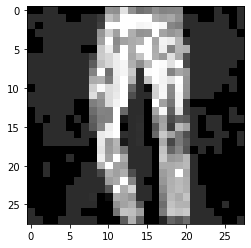

In [32]:
# Visualize perturbed image
challenge_xprime = np.array(new_xprime)
plt.imshow(new_xprime[0][5], cmap = 'gray')

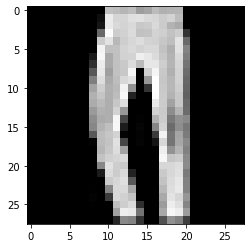

In [33]:
# Visualize original image
plt.imshow(x_test[5], cmap = 'gray')

For the below code to run, first create a folder named *perturbed_images*

In [34]:
# Save perturbed images
for i in range(challenge_xprime.shape[1]):
  plt.imsave('/content/perturbed_images/perturbed_img'+str(i)+'.png', challenge_xprime[0][i], cmap = 'gray')

In [ ]:
files.download('/content/perturbed_images')

In [36]:
!zip -r /content/perturbed_images.zip /content/perturbed_images

Streaming output truncated to the last 5000 lines.
  adding: content/perturbed_images/perturbed_img6497.png (stored 0%)
  adding: content/perturbed_images/perturbed_img6730.png (stored 0%)
  adding: content/perturbed_images/perturbed_img682.png (stored 0%)
  adding: content/perturbed_images/perturbed_img2815.png (stored 0%)
  adding: content/perturbed_images/perturbed_img1135.png (stored 0%)
  adding: content/perturbed_images/perturbed_img6015.png (stored 0%)
  adding: content/perturbed_images/perturbed_img4431.png (stored 0%)
  adding: content/perturbed_images/perturbed_img7243.png (stored 0%)
  adding: content/perturbed_images/perturbed_img5839.png (stored 0%)
  adding: content/perturbed_images/perturbed_img3746.png (stored 0%)
  adding: content/perturbed_images/perturbed_img9119.png (stored 0%)
  adding: content/perturbed_images/perturbed_img9674.png (stored 0%)
  adding: content/perturbed_images/perturbed_img4699.png (stored 0%)
  adding: content/perturbed_images/perturbed_img4244.

In [37]:
# Download perturbed images
files.download('/content/perturbed_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>